<a href="https://colab.research.google.com/github/tusharnandy/MLProjects/blob/master/xor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing relevant libraries

In [61]:
import torch

In [62]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

Creating a data class

In [63]:
class Data(Dataset):
    def __init__(self, x,y): # taking input as coordinates:x and the labels:y
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return self.x[index], self.y[index] # Overwriting the __getitem__ and __len__ methods

    def __len__(self):
      return len(self.x)

In [64]:
assign = lambda x: -np.sign(np.sign(x)-1) # this function assigns the appropriate label based on the product of the coordinates

data_full = np.array([[v[0],v[1],assign(v[0]*v[1])] for v in np.random.uniform(-1,1,(10_000,2))])
# Creating an array consisting of elements: [x-coord, y-coord, label]

# dividing into x and y
x_train, y_train = data_full[:7000, :2], data_full[:7000, 2].astype('int') # since we are dealing with a classification problem, we need the labels to be int

x_validation, y_validation = data_full[7000:8500, :2], data_full[7000:8500, 2].astype('int')

x_test, y_test = data_full[8500:, :2], data_full[8500:, 2].astype('int')

In [65]:
xor_train = Data(x_train, y_train)
xor_valid = Data(x_validation, y_validation)

train_dl = DataLoader(xor_train, batch_size=16, shuffle=True)
validation_dl = DataLoader(xor_valid, batch_size=1500) # keeping the whole validation dataset into one batch works well for this problem
                                                       # However, this might not be the case while dealing with larger traing/validation data

In [66]:
class Model(nn.Module):
    def __init__(self, hidden_layer_size=4):
        super(Model, self).__init__()
        self.lin1 = nn.Linear(2,hidden_layer_size)
        self.lin2 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.tanh(self.lin2(x))
        return x

In [67]:
loss_func = nn.BCEWithLogitsLoss() # cross entropy threw some error that I could not debug

As far as the other loss functions are concerned, MSE works best for regression problems, and it turns out that cross entropy is the same as logsoftmax + NLLloss

In [68]:
# This function will be called to compute the loss, and for forward and backprop
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb.float()), yb.view(yb.shape[0], 1).float())

    if opt is not None: # For validation data, we only need to compute the loss. Hence, the optimizer will not be used
        
        loss.backward() # the calculated loss is passed back to the model
        opt.step() # the optimizer calculates the gradients and updates the weights and biases
        opt.zero_grad() # gradients set to zero

    return loss.item(), len(xb)

In [69]:
from torch import optim

In [70]:
'''In order to compute the accuracy,  we will first convert all ouputs greater than 0.5 to 1, and vice-versa. '''

def accuracy(out, yb):
    arr = np.array([float(int( out[i] + 0.5 ) == yb[i]) for i in range(len(out))])
    return arr.mean()

In [71]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    loss_val = []
    acc_val = []
    
    loss_train = []
    acc_train = []
    
    for epoch in range(epochs):
        model.train()
        
        temploss = []
        tempacc = []
        
        for xb, yb in train_dl:
            train_loss, num = loss_batch(model, loss_func, xb, yb, opt)
            
            temploss.append([train_loss,num])
            tempacc.append([accuracy(model(xb.float()), yb), num])

        losses_train, nums = zip(*temploss)
        accuracy_train, nums = zip(*tempacc)

        train_loss = np.sum(np.multiply(losses_train, nums)) / np.sum(nums)
        train_acc = np.sum(np.multiply(accuracy_train, nums)) / np.sum(nums)

        loss_train.append(train_loss)
        acc_train.append(train_acc)
        
        model.eval()
        with torch.no_grad():
            losses_val, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        
        # validation loss
        val_loss = np.sum(np.multiply(losses_val, nums)) / np.sum(nums)
        loss_val.append(val_loss)

        # validation accuracy
        acc_temp = []
        for xb,yb in validation_dl:
          acc_temp.append(accuracy(model(xb.float()), yb))
        
        acc_val.append(np.array(acc_temp).mean())
    
    return loss_val, acc_val, loss_train, acc_train

In [72]:
lr = 1e-3
model = Model()
opt = optim.SGD(model.parameters(), lr=lr)

In [ ]:
validation_loss, validation_accuracy, training_loss, training_accuracy  = fit(100, model, loss_func, opt, train_dl, validation_dl)

In [74]:
import matplotlib.pyplot as plt

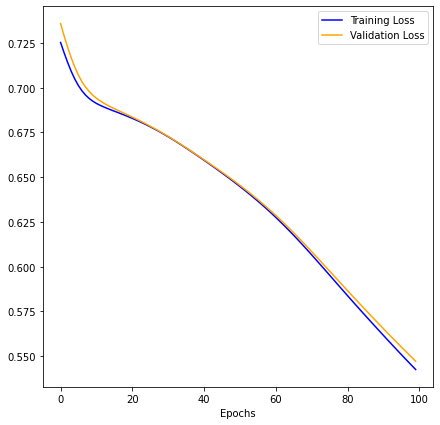

In [75]:
plt.figure(figsize=(7,7))
plt.plot(list(range(100)), training_loss, color='b', label='Training Loss')
plt.plot(list(range(100)), validation_loss, color='orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

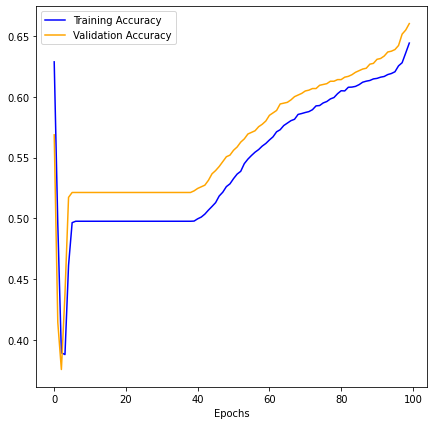

In [76]:
plt.figure(figsize=(7,7))
plt.plot(list(range(100)), training_accuracy, color='b', label='Training Accuracy')
plt.plot(list(range(100)), validation_accuracy, color='orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [77]:
# Since we only require the validation loss, the code can be shortened accordingly
def fit_(epochs, model, loss_func, opt, train_dl, valid_dl):
    loss_val = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        
        model.eval()
        with torch.no_grad():
            losses_val, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        
        # validation loss
        val_loss = np.sum(np.multiply(losses_val, nums)) / np.sum(nums)
        loss_val.append(val_loss)

        # print(epoch, val_loss, train_loss)
    
    return loss_val

In [78]:
def get_model(lr=1e-3, hls=4):
  model_ = Model(hidden_layer_size=hls)
  opt_ = optim.SGD(model.parameters(), lr=lr)
  return model_, opt_ 

In [79]:
best_losses_hls = []
hidden_layer_sizes = [2,4,6,8,10]

for hidden_layer_size in hidden_layer_sizes:
  model, opt = get_model(hls=hidden_layer_size)
  losses = fit_(20,model,loss_func,opt,train_dl,validation_dl)
  best_losses_hls.append(np.array(losses).min())

# plt.fig(figsize=(7,7))
# plt.stem(hidden_layer_sizes,best_losses_hls)

best_loss = min(best_losses_hls)
best_hidden_layer = hidden_layer_sizes[best_losses_hls.index(best_loss)]
print(best_hidden_layer)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

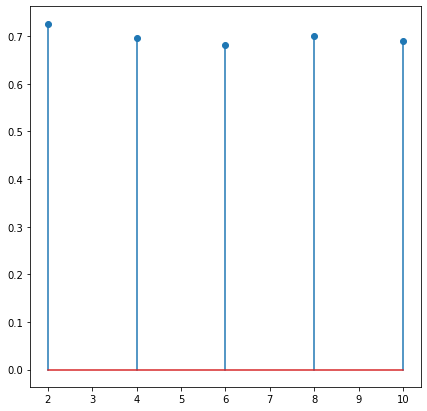

In [80]:
plt.figure(figsize=(7,7))
plt.stem(hidden_layer_sizes,best_losses_hls)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


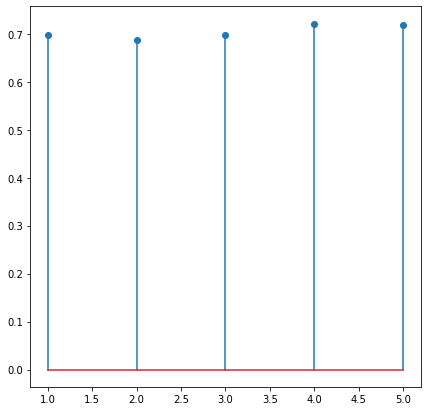

In [81]:
best_losses_lr = []
learning_rates = [5,4,3,2,1]

for power in learning_rates:
  model, opt = get_model(lr=10 ** -power)
  losses = fit_(20,model,loss_func,opt,train_dl,validation_dl)
  best_losses_lr.append(np.array(losses).min())

plt.figure(figsize=(7,7))
plt.stem(learning_rates,best_losses_lr)
best_lr = learning_rates[best_losses_lr.index(min(best_losses_lr))]
print(best_lr)

In [82]:
print(f"best learning rate: {10 ** -best_lr}")

best learning rate: 0.01


In [83]:
lr = 10 ** (-best_lr)
model = Model(hidden_layer_size=best_hidden_layer)
opt = optim.SGD(model.parameters(), lr=lr)
_,_,_,_ = fit(100, model, loss_func, opt, train_dl, validation_dl)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [84]:
# contain in color

x_test_tensor, y_test_tensor = map(torch.Tensor, (x_test, y_test))
y_pred = [int(i>=0.5) for i in model(x_test_tensor.float())]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [85]:
accuracy(y_pred,y_test)

0.95

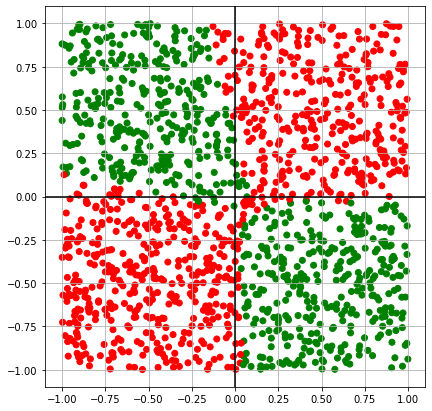

In [86]:
color_map = []

for i in y_pred:
  if i == 1:
    color_map.append('g')
  else:
    color_map.append('r')

fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
ax.scatter(x_test[:,0], x_test[:,1], c=color_map)
ax.set_aspect('equal')
ax.grid(True, which='both')

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')